# Group: Gonçalo Nuno Matos Gomes     m20211007

In [ ]:
!pip install mplfinance
!pip install ccxt
!pip install ta
!pip install backtrader
!pip install quantstats

### Project Guidelines

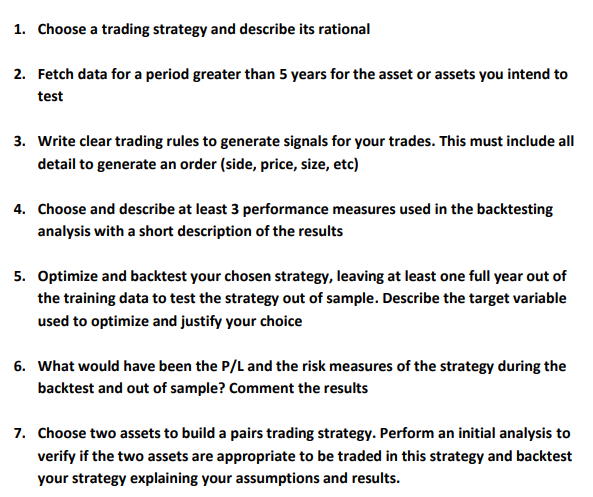

### Libraries

In [159]:
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import ccxt
import pandas as pd
from datetime import datetime
from ta import add_all_ta_features
from ta.utils import dropna
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, EMAIndicator
import backtrader as bt
import quantstats as qs
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression

### 1. Choose a trading strategy and describe its rational

This trading strategy is designed to identify high probability swing trading opportunities by combining four key technical indicators, each playing a specific role in the decision-making process:

1. Stochastic RSI for signal generation;
2. RSI for trend validation;
3. MACD for momentum confirmation;
4. EMA sobreposition for entry timing;

By combining these indicators, my goal is to reduce false signals and improve my entry position

* The Stochastic RSI is used to generate the initial signal. It measures the closing price relative to the recent high-low range over a 14-period window and outputs two lines: %K (the raw value) and %D (a smoothed average of %K). When both lines fall below 25, it is suggesting that the price is in oversold conditions and when they rise above 75, the market is considered overbought. These levels serve as potential turning points and trigger the first level of interest for a trade.

* To validate whether price action is aligned with a broader trend, I decided to take into consideration the RSI. This indicator compares recent gains to recent losses and outputs a scaled value vetween 0 and 100. Rather than using it for overbought or oversold signals, this strategy interprets RSI values above 50 as a bullish trend and values below 50 as a bearish trend. This helps confirm that any signals from the Stochastic RSI.

* Momentum is further validated using the MACD, which compares a fast and slow exponential moving average, typically the 12 and 26-period EMAs. The MACD line is then compared to a 9-period EMA signal line. When the MACD line is above the signal line, it assumes that we are in a bullish mommentum and when it is below, bearish momentum is expected. This indicator helps avoid entries when signals occur in weak momentum conditions.

* For additional confirmation and trend alignment, the strategy incorporates the relative positioning of the 12-period and 21-period EMAs. A long entry is only considered when the 12 EMA is above the 21 EMA, signaling short-term bullish momentum. Conversely, a short entry is only taken when the 12 EMA is below the 21 EMA, indicating bearish momentum. Rather than relying on EMA crossovers as a signal on their own, this condition serves as a directional filter to improve entry timing and reduce trades taken against the prevailing trend.

--> In order to manage risk, I decided that I will implement a structure-based stop loss. For long trades, the stop loss is placed just below the most recent swing low. For short trades, it is set just above the most recent swing high. This approach aligns the stop loss with key technical levels, ensuring the trade is only exited if price action invalidates the original setup.

--> Finally, I determined trade exits using a fixed 1:3 risk/reward ratio. Upon entering a position, the take-profit level is calculated as three times the distance between the entry price and the predefined stop loss. This ensures that for every unit of risk, the strategy targets three units of potential reward.

### 2. Fetch data for a period greater than 5 years for the asset or assets you intend to test

In [37]:
# Fetching more than 5 years of daily data for ADA-USD

ada = yf.download("ADA-USD", start = "2018-01-01", end = "2024-12-31", interval = "1d", progress = False)

# Flattening the multi index from the fetched data because we don't need the "ADA-USD" label in each column

ada.columns = [col if isinstance(col, str) else col[0] for col in ada.columns]

# Dropping observations with null values

ada.dropna(inplace=True)

print(ada.head())
print(f"\nData covers: {ada.index[0].date()} to {ada.index[-1].date()}")

               Close      High       Low      Open     Volume
Date                                                         
2018-01-01  0.728657  0.730051  0.671941  0.718847  150186000
2018-01-02  0.782587  0.794646  0.697856  0.724676  289712000
2018-01-03  1.079660  1.085670  0.778578  0.779681  657398016
2018-01-04  1.114120  1.327210  1.037650  1.094030  593430016
2018-01-05  0.999559  1.252420  0.903503  1.171150  508100000

Data covers: 2018-01-01 to 2024-12-30


In [38]:
# Saving the fetched data for later use

ada.to_csv("/content/drive/MyDrive/Nova Ims/Algorithmic Trading/ada_usd_5y.csv")

### 3. Write clear trading rules to generate signals for your trades. This must include all detail to generate an order (side, price, size, etc)


In [89]:
import backtrader as bt

# Conceptually defining the previously described trading strategy

class ADA_Strategy(bt.Strategy):

    # Strategy parameters

    params = dict(
        rsi_period=14,
        stoch_k_period=14,
        stoch_d_period=3,
        swing_window=5  # Number of candles to look back in order to set up the stop loss
    )

    # Initializing the indicators

    def __init__(self):

        # RSI indicator to confirm trend direction

        self.rsi = bt.ind.RSI(self.data, period=self.p.rsi_period)

        # Stochastic fast oscillator for overbought and oversold signals

        stochastic = bt.ind.StochasticFast(self.data, period=self.p.stoch_k_period, period_dfast=self.p.stoch_d_period)
        self.stoch_k = stochastic.percK
        self.stoch_d = stochastic.percD

        self.ema12 = bt.ind.EMA(self.data, period=12)
        self.ema21 = bt.ind.EMA(self.data, period=21)

        # Tracking the entry position and exit

        self.entry_price = None
        self.stop_price = None
        self.take_profit = None
        self.entry_date = None
        self.trade_side = None

        # Store all trades for post-analysis

        self.trades = []

    # Entry logic

    def next(self):

        if not self.position:

            # Long entry conditions

            if self.rsi[0] > 50 and self.stoch_k[0] < 25 and self.ema12[0] > self.ema21[0]:

                # Identifying the most recent swing low for the stop loss

                swing_low = min(self.data.low.get(size=self.p.swing_window))

                # Placing the buy order

                self.buy()

                # Storing the entry price and the stop loss

                self.entry_price = self.data.close[0]
                self.stop_price = swing_low

                # Defining the take profit as a 3:1 risk/reward ratio based on the distance to the stop loss

                risk = self.entry_price - self.stop_price
                self.take_profit = self.entry_price + 3 * risk
                self.entry_date = self.datetime.date(0)
                self.trade_side = 'Long'

            # Short entry conditions

            elif self.rsi[0] < 50 and self.stoch_k[0] > 75 and self.ema12[0] < self.ema21[0]:

                # Identifying the most recent swing high for the stop loss

                swing_high = max(self.data.high.get(size=self.p.swing_window))

                # Placing a short entry position

                self.sell()

                # Storing both the entry price and stop loss

                self.entry_price = self.data.close[0]
                self.stop_price = swing_high

                # Defining the take profit method the same way as for the long positions (1:3)

                risk = self.stop_price - self.entry_price
                self.take_profit = self.entry_price - 3 * risk
                self.entry_date = self.datetime.date(0)
                self.trade_side = 'Short'

        # Exiting a long position

        elif self.position.size > 0:

            # If the stop loss hits

            if self.data.close[0] <= self.stop_price:
                exit_price = self.data.close[0]
                exit_date = self.datetime.date(0)
                pnl = (exit_price - self.entry_price) * self.position.size

                # Log the closed long trade

                self.trades.append({
                    'Side': self.trade_side,
                    'Entry Date': self.entry_date,
                    'Entry Price': self.entry_price,
                    'Exit Date': exit_date,
                    'Exit Price': exit_price,
                    'P/L': pnl,
                    'Stop Loss': self.stop_price,
                    'Take Profit': self.take_profit
                })

                self.close()

            # If the take profit hits

            elif self.data.close[0] >= self.take_profit:
                exit_price = self.data.close[0]
                exit_date = self.datetime.date(0)
                pnl = (exit_price - self.entry_price) * self.position.size

                # Log the closed long trade

                self.trades.append({
                    'Side': self.trade_side,
                    'Entry Date': self.entry_date,
                    'Entry Price': self.entry_price,
                    'Exit Date': exit_date,
                    'Exit Price': exit_price,
                    'P/L': pnl,
                    'Stop Loss': self.stop_price,
                    'Take Profit': self.take_profit
                })

                self.close()

        # Exiting a short position

        elif self.position.size < 0:

            # If the stop loss hits

            if self.data.close[0] >= self.stop_price:
                exit_price = self.data.close[0]
                exit_date = self.datetime.date(0)
                pnl = (self.entry_price - exit_price) * abs(self.position.size)

                # Log the closed short trade

                self.trades.append({
                    'Side': self.trade_side,
                    'Entry Date': self.entry_date,
                    'Entry Price': self.entry_price,
                    'Exit Date': exit_date,
                    'Exit Price': exit_price,
                    'P/L': pnl,
                    'Stop Loss': self.stop_price,
                    'Take Profit': self.take_profit
                })

                self.close()

            # If the take profit hits

            elif self.data.close[0] <= self.take_profit:
                exit_price = self.data.close[0]
                exit_date = self.datetime.date(0)
                pnl = (self.entry_price - exit_price) * abs(self.position.size)

                # Log the closed short trade

                self.trades.append({
                    'Side': self.trade_side,
                    'Entry Date': self.entry_date,
                    'Entry Price': self.entry_price,
                    'Exit Date': exit_date,
                    'Exit Price': exit_price,
                    'P/L': pnl,
                    'Stop Loss': self.stop_price,
                    'Take Profit': self.take_profit
                })

                self.close()

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')


In [90]:
# Feeding to backtrader

data = bt.feeds.PandasData(dataname=ada)

# Initializing Cerebro

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(ADA_Strategy)

# Setting the order details: Cash, Commision and Size

cerebro.broker.setcash(10_000)
cerebro.broker.setcommission(commission=0.001)  # 0.1% per trade
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)  # Use 50% of equity per trade

* As I already mentioned, in this strategy, trading orders are generated based on technical signal conditions evaluated during each bar. The side of the trade is determined by the directional bias of the entry logic in which a buy order is placed for long entries when bullish criteria are met, and a sell order is placed for short entries when bearish criteria are present.

* The entry price is taken as the current's bar closing price at the time that the signal is triggered, which simmulates a market order placed at the bar's close.
* The position size was configured to allocate 50% of available equity to each trade, in order to ensure proper compunding during backtesting.
* The initial cash was set to 10.000$ and include a 0.1% transacction cost per trade, which represents a realistic commision structure in crypto trading.

Also, all orders are being immedietely executed upon signal generation, assuming sufficient capital and no conflict with other open positions.

### 4. Choose and describe at least 3 performance measures used in the backtesting analysis with a short description of the results


* The first performance metric that I will use is the Sharpe Ratio, which measures the strategy's risk-adjusted return by comparing excess returns to portfolio volatility. Since the cryptocurrency market is naturally volatile, it's important to ensure that returns are not only positive but also efficient relative to the amount of risk being taken.

* The second measure is the Maximum Drawdown which provides insight into the strategy’s largest observed loss from peak to trough during the backtest. This is particularly relevant because the stop-loss levels are structure-based, and large drawdowns could indicate a need to better manage risk or size down my positions

* The other measure I will use is the Profit Factor, which is defined as the ratio of gross profits to gross losses. It offers a direct view into whether the magnitude of winning trades exceeds that of losing trades, regardless of the number of trades taken. This strategy is designed around a fixed 1:3 risk/reward ratio which means that a profit factor greater than 1 confirms that the edge is materializing as expected.

Starting Value: 10,000.00
Ending   Value: 15,137.51
Return:				41.4591%
Sharpe Ratio:			0.397
Max Drawdown:			14.65%
Payoff Ratio:			1.653


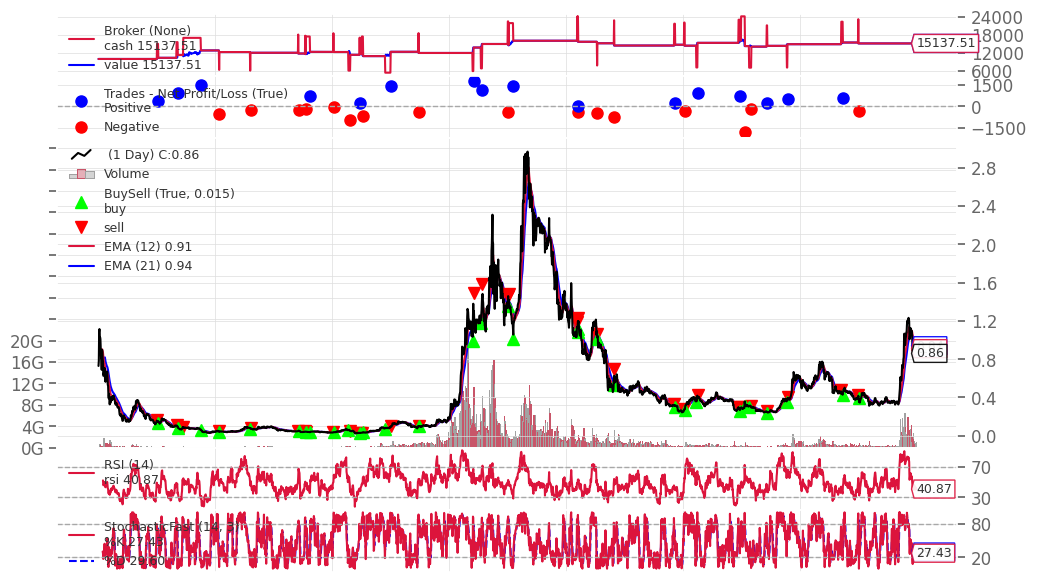

[[<Figure size 1000x600 with 6 Axes>]]

In [91]:
# Adding the analyzers

# Sharp Ratio
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
# Max Drawdown
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
# Cumulative Return
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
#transaction log --> Debugging purposes
cerebro.addanalyzer(bt.analyzers.Transactions, _name='trades')
# Payoff ratio
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')

# backtesting the strategy

results = cerebro.run()
strat = results[0]

# Retrieving the analysis object

ta = strat.analyzers.ta.get_analysis()

# Extracting the strategy payoff

def get_payoff_ratio(ta):
    try:
        return ta['won']['pnl']['average'] / abs(ta['lost']['pnl']['average'])
    except (KeyError, ZeroDivisionError, TypeError):
        return None

# Performance Outputs

print("===================================================")
# Normalized Return per year
print(f"Return:\t\t\t\t{strat.analyzers.returns.get_analysis()['rtot']:.4%}")
print(f"Sharpe Ratio:\t\t\t{strat.analyzers.sharpe.get_analysis()['sharperatio']:.3f}")
print(f"Max Drawdown:\t\t\t{strat.analyzers.dd.get_analysis()['max']['drawdown']:.2f}%")

payoff_ratio = get_payoff_ratio(ta)
if payoff_ratio is not None:
    print(f"Payoff Ratio:\t\t\t{payoff_ratio:.3f}")
else:
    print("Payoff Ratio:\t\t\tN/A")
print("===================================================")

# Plotting the results

cerebro.plot(iplot=False)

Based on the backtest results, my strategy achieved a total return of 41.72%, growing the initial capital from 10,000 dollars to 15,137.51 dollars.
* However, the Sharpe Ratio of 0.397 suggests that the returns were not particularly efficient relative to the volatility, indicating that there is a moderate risk-adjusted performance.
* The maximum drawdown of 14.65% shows that the strategy experienced a noticeable but manageable dip during the backtested period.
* Finally, the Payoff Ratio of 1.653 confirms that, on average, winning trades were approximately 1.65 times larger than losing trades, which supports the idea that the 1:3 risk/reward logic is partially materializing, although not fully because of to early exits or stop-losses.

### 5.) Optimize and backtest your chosen strategy, leaving at least one full year out of the training data to test the strategy out of sample. Describe the target variable used to optimize and justify your choice


In [92]:
# Spliting into train and test sets

train_data = ada[ada.index < '2023-01-01']
test_data = ada[ada.index >= '2023-01-01']

print("Training set:", train_data.index.min().date(), "→", train_data.index.max().date())
print("Testing set: ", test_data.index.min().date(), "→", test_data.index.max().date())

Training set: 2018-01-01 → 2022-12-31
Testing set:  2023-01-01 → 2024-12-30


In [98]:
# Running the optimization process

train_feed = bt.feeds.PandasData(dataname=train_data)
cerebro = bt.Cerebro()
cerebro.adddata(train_feed)

# Optimizing the following parameters: swing_window, ema_fast, ema_slow

cerebro.optstrategy(
    ADA_Optimized,
    swing_window=range(3, 8),
    ema_fast=range(10, 16),
    ema_slow=range(18, 26)
)

# Order details are the same as before

cerebro.broker.setcash(10_000)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

results = cerebro.run()

# Extracting the best sharp ratio combination

best_result = None
best_sharpe = float('-inf')

for res in results:
    strat = res[0]
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio')
    if sharpe and sharpe > best_sharpe:
        best_sharpe = sharpe
        best_result = strat
        best_params = strat.params

print("================ BEST SHARPE STRATEGY ================")
print(f"Sharpe Ratio: {best_sharpe:.3f}")
print(f"Best Params: Swing={best_params.swing_window}, EMA Fast={best_params.ema_fast}, EMA Slow={best_params.ema_slow}")
print("======================================================")

================ BEST SHARPE STRATEGY ================
Sharpe Ratio: 0.473
Best Params: Swing=4, EMA Fast=10, EMA Slow=18


* In order to optimize the developed strategy, the Sharpe Ratio was selected as the target performance metric. I made this decision based on the need to balance both return and risk. This choice was also supported by previous backtesting results, where the Sharpe Ratio over the full dataset was only 0.397, indicating that while the strategy was profitable, its returns were relatively inefficient compared to the risk taken.

* By targeting an improvement in the Sharpe Ratio, the goal was to enhance the strategy’s risk adjusted return, ensuring not only profitability but greater consistency in performance. Following the optimization, the best-performing configuration achieved a Sharpe Ratio of 0.473, with the parameters: swing_window = 4, ema_fast = 10, and ema_slow = 18. This suggests that the selected configuration improves the risk/reward profile of the strategy, addressing one of its earlier weaknesses.

### 6. What would have been the P/L and the risk measures of the strategy during the backtest and out of sample? Comment the results


==== TRAINING RESULTS ====
Starting Value:			$10,000.00
Ending Value:			$14,703.63
Return:				38.5509%
Sharpe Ratio:			0.473
Max Drawdown:			14.65%
Payoff Ratio:			2.066


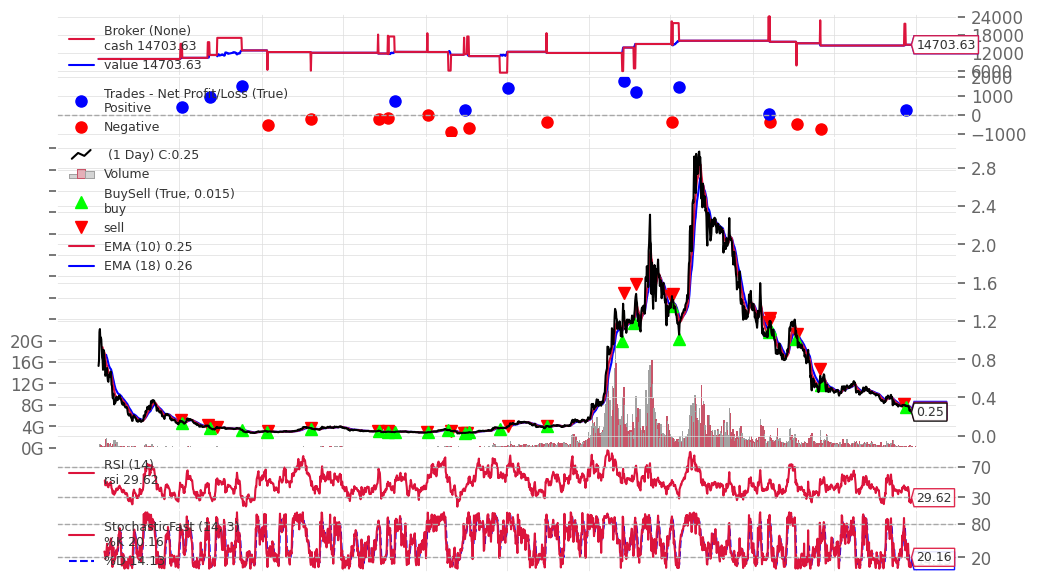


==== OUT-OF-SAMPLE RESULTS ====
Starting Value:			$10,000.00
Ending Value:			$10,521.52
Return:				5.0837%
Sharpe Ratio:			1.801
Max Drawdown:			14.20%
Payoff Ratio:			0.797


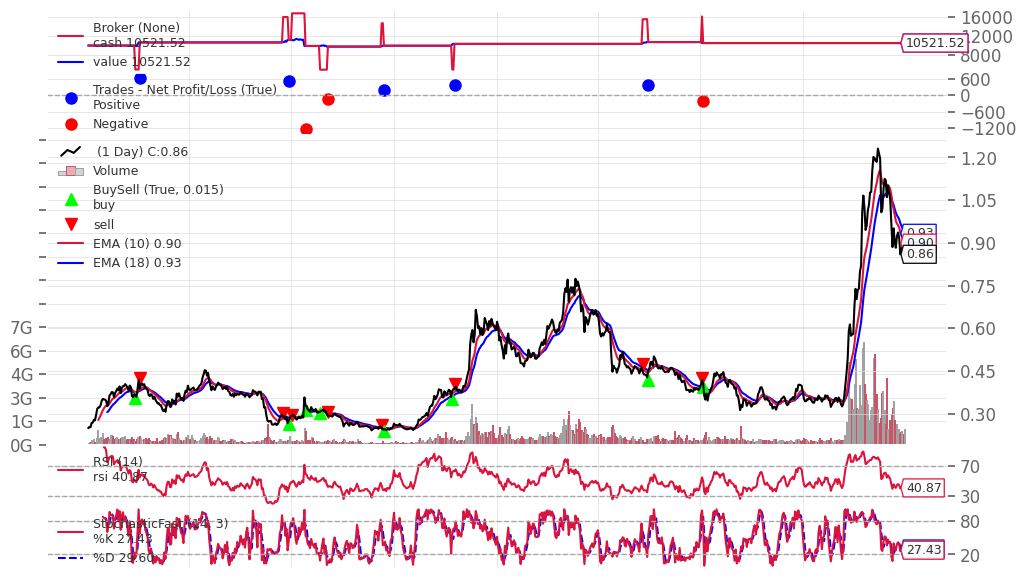

In [102]:
# Defining the developed strategy with the best parameters

class ADA_BestParams(bt.Strategy):

    params = dict(
        rsi_period=14,
        stoch_k_period=14,
        stoch_d_period=3,
        swing_window=4,
        ema_fast=10,
        ema_slow=18
    )

    def __init__(self):
        self.rsi = bt.ind.RSI(self.data, period=self.p.rsi_period)
        stochastic = bt.ind.StochasticFast(self.data, period=self.p.stoch_k_period, period_dfast=self.p.stoch_d_period)
        self.stoch_k = stochastic.percK
        self.stoch_d = stochastic.percD
        self.ema_fast = bt.ind.EMA(self.data, period=self.p.ema_fast)
        self.ema_slow = bt.ind.EMA(self.data, period=self.p.ema_slow)

        self.entry_price = None
        self.stop_price = None
        self.take_profit = None
        self.entry_date = None
        self.trade_side = None

    def next(self):
        if not self.position:
            if self.rsi[0] > 50 and self.stoch_k[0] < 25 and self.ema_fast[0] > self.ema_slow[0]:
                swing_low = min(self.data.low.get(size=self.p.swing_window))
                self.buy()
                self.entry_price = self.data.close[0]
                self.stop_price = swing_low
                risk = self.entry_price - self.stop_price
                self.take_profit = self.entry_price + 3 * risk

            elif self.rsi[0] < 50 and self.stoch_k[0] > 75 and self.ema_fast[0] < self.ema_slow[0]:
                swing_high = max(self.data.high.get(size=self.p.swing_window))
                self.sell()
                self.entry_price = self.data.close[0]
                self.stop_price = swing_high
                risk = self.stop_price - self.entry_price
                self.take_profit = self.entry_price - 3 * risk

        elif self.position.size > 0:
            if self.data.close[0] <= self.stop_price or self.data.close[0] >= self.take_profit:
                self.close()

        elif self.position.size < 0:
            if self.data.close[0] >= self.stop_price or self.data.close[0] <= self.take_profit:
                self.close()

# Backtesting

def run_backtest(data, label=""):
    cerebro = bt.Cerebro()
    datafeed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(datafeed)
    cerebro.addstrategy(ADA_BestParams)
    cerebro.broker.setcash(10_000)
    cerebro.broker.setcommission(commission=0.001)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=50)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')

    results = cerebro.run()
    strat = results[0]
    ta = strat.analyzers.ta.get_analysis()

    def get_payoff_ratio(ta):
        try:
            return ta['won']['pnl']['average'] / abs(ta['lost']['pnl']['average'])
        except (KeyError, ZeroDivisionError, TypeError):
            return None

    print(f"\n==== {label.upper()} RESULTS ====")
    print(f"Starting Value:\t\t\t$10,000.00")
    print(f"Ending Value:\t\t\t${cerebro.broker.getvalue():,.2f}")
    print(f"Return:\t\t\t\t{strat.analyzers.returns.get_analysis()['rtot']:.4%}")
    print(f"Sharpe Ratio:\t\t\t{strat.analyzers.sharpe.get_analysis()['sharperatio']:.3f}")
    print(f"Max Drawdown:\t\t\t{strat.analyzers.dd.get_analysis()['max']['drawdown']:.2f}%")
    payoff_ratio = get_payoff_ratio(ta)
    print(f"Payoff Ratio:\t\t\t{payoff_ratio:.3f}" if payoff_ratio else "Payoff Ratio:\t\t\tN/A")

    # Plotting the results

    cerebro.plot(iplot=False)

# Running both backtests

run_backtest(train_data, label="Training")
run_backtest(test_data, label="Out-of-Sample")

* During the training period, the strategy delivered a strong return of 38.55%, growing the initial $10,000 to $14,703.63. The Sharpe Ratio stood at 0.473, indicating moderate risk-adjusted performance, while the Max Drawdown was at 14.65%, suggesting acceptable downside exposure. The Payoff Ratio reached 2.066, showing that average gains were more than twice the average losses.

* When applied to the test period, the strategy achieved a more modest return of 5.08%, ending at $10,521.52. Interestingly, despite the lower return, the Sharpe Ratio increased to 1.801, indicating that the strategy performed with significantly greater consistency and lower volatility in this phase. The Max Drawdown remained nearly identical at 14.20%, reflecting a stable risk profile. However, the Payoff Ratio dropped to 0.797, suggesting that while losses were better managed, the magnitude of winning trades was smaller than those during the training phase.

--> Overall, the results show that the strategy successfully generalized out of sample, maintaining profitability and improving its consistency. While the profit margin decreased, the risk-adjusted return actually improved.

### 7. Choose two assets to build a pairs trading strategy. Perform an initial analysis to verify if the two assets are appropriate to be traded in this strategy and backtest your strategy explaining your assumptions and results.

In [158]:
# Finding pairs using a top-down method

# Defining the candidate pairs manually based on industry or economic similarity

pairs = [
    ('UL', 'PG'),         # Consumer Goods
    ('WMT', 'TGT'),       # Retail
    ('NVDA', 'AMD'),      # Semiconductors
    ('BAC', 'WFC'),       # Banking
    ('MRK', 'BMY'),       # Pharmaceuticals
    ('TSLA', 'NIO'),      # EV/Automotive
    ('GS', 'MS'),         # Investment Banks
    ('COST', 'BJ'),       # Wholesale/Retail
    ('EWI', 'EWG'),       # Country ETFs (Italy vs. Germany)
]

# Consistently setting the analysis period

start = '2018-01-01'
end = '2024-12-31'

# List to store metrics for each pair

results = []

# Looping through each pair

for pair in pairs:
    try:
        raw = yf.download(pair, start=start, end=end)

        df = raw['Close'].dropna()

        asset_A, asset_B = pair
        price_A = df[asset_A]
        price_B = df[asset_B]

        # Computing the rolling 90-day correlation

        rolling_corr = price_A.rolling(90).corr(price_B)
        avg_corr = rolling_corr.mean()

        # Performing the Engle-Granger cointegration test

        score, pvalue, _ = coint(price_A, price_B)

        # Estimating the hedge ratio via linear regression

        hedge_ratio = np.polyfit(price_B, price_A, 1)[0]
        spread = price_A - hedge_ratio * price_B

        # Normalizing the spread into a Z-score to estimate mean-reversion behavior

        zscore = (spread - spread.mean()) / spread.std()
        zscore_std = zscore.std()

        # Pair metrics

        results.append({
            'Pair': f"{asset_A}-{asset_B}",
            'Avg Correlation': avg_corr,
            'Cointegration p-value': pvalue,
            'Z-Score Std Dev': zscore_std
        })

        print(f"Processed: {asset_A}-{asset_B}")

    except Exception as e:
        print(f"Error processing {pair}: {e}")

# Compiling the results into a DataFrame and sort by cointegration

results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df = results_df.sort_values(by='Cointegration p-value')
    print(results_df)
else:
    print("No results collected")


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed

✅ Processed: UL-PG



[*********************100%***********************]  2 of 2 completed

✅ Processed: WMT-TGT



[*********************100%***********************]  2 of 2 completed

✅ Processed: NVDA-AMD



[*********************100%***********************]  2 of 2 completed

✅ Processed: BAC-WFC



[*********************100%***********************]  2 of 2 completed

✅ Processed: MRK-BMY



[*********************100%***********************]  2 of 2 completed

✅ Processed: TSLA-NIO



[*********************100%***********************]  2 of 2 completed

✅ Processed: GS-MS



[*********************100%***********************]  2 of 2 completed

✅ Processed: COST-BJ


✅ Processed: EWI-EWG
       Pair  Avg Correlation  Cointegration p-value  Z-Score Std Dev
0     UL-PG         0.473795               0.429849              1.0
6     GS-MS         0.843271               0.445275              1.0
3   BAC-WFC         0.771694               0.518182              1.0
7   COST-BJ         0.330973               0.759480              1.0
8   EWI-EWG         0.877662               0.759637              1.0
4   MRK-BMY         0.244326               0.793896              1.0
5  TSLA-NIO         0.423080               0.940319              1.0
2  NVDA-AMD         0.634822               0.993505              1.0
1   WMT-TGT         0.384319               1.000000              1.0


* Based on the output, I selected the GS–MS pair because it showed the most promising characteristics for a pairs trading strategy. Among all the candidate pairs, it had the highest average correlation (0.84) and one of the lowest cointegration p-values (0.44).

In [163]:
# Preparing time series data for the selected pair (GS-MS)


# Downloading the daily close prices for the selected pair

tickers = ['GS', 'MS']
data = yf.download(tickers, start='2018-01-01', end='2024-12-31', interval='1d')

# Extract closing prices

data = data['Close'][['GS', 'MS']].dropna()

# Estimating the hedge ratio

x = data['MS'].values.reshape(-1, 1)
y = data['GS'].values.reshape(-1, 1)  # target
d_model = LinearRegression().fit(x, y)
beta = model.coef_[0][0]

# Computing the spread and Z-score

data['Spread'] = data['GS'] - beta * data['MS']
data['Zscore'] = (data['Spread'] - data['Spread'].rolling(30).mean()) / data['Spread'].rolling(30).std()

data = data.dropna()
print(f"Estimated hedge ratio (beta): {beta:.4f}")

data.head()

[*********************100%***********************]  2 of 2 completed

Estimated hedge ratio (beta): 3.9909


Ticker,GS,MS,Spread,Zscore
Date,,,,
2018-02-13,217.440796,43.087402,45.485206,0.484390
2018-02-14,223.439957,44.427082,46.137899,0.725196
2018-02-15,227.779724,44.709557,49.350352,1.564222
2018-02-16,227.728683,44.499702,50.136809,1.712706
2018-02-20,225.405655,44.435150,48.071399,1.150385


In [164]:
# Getting signal generation and defining the execution logic

# Downloading close prices (same as before)

tickers = ['GS', 'MS']
data = yf.download(tickers, start='2018-01-01', end='2024-12-31', interval='1d')

# Extracting Closing prices

data = data['Close'][['GS', 'MS']].dropna()

# Estimating hedge ratio using linear regression

x = data['MS'].values.reshape(-1, 1)
y = data['GS'].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)
beta = model.coef_[0][0]

# Computing the spread and its Z-score for standardized signal generation

data['Spread'] = data['GS'] - beta * data['MS']
data['Zscore'] = (data['Spread'] - data['Spread'].rolling(30).mean()) / data['Spread'].rolling(30).std()
data = data.dropna()

# Step 5: Generating the trading signals and simulate trades
# Enter long spread if Z < -1
# Enter short spread if Z > 1
# Exit when Z-score reverts toward zero (< 0.5)

position = 0
entry_price = 0
entry_date = None
returns = []

for i in range(1, len(data)):
    z = data['Zscore'].iloc[i]
    spread = data['Spread'].iloc[i]
    date = data.index[i]

    if position == 0:
        if z < -1:
            # Long spread (buy GS, short MS)
            position = 1
            entry_price = spread
            entry_date = date
        elif z > 1:
            # Short spread (short GS, buy MS)
            position = -1
            entry_price = spread
            entry_date = date

    elif position != 0:
        if abs(z) < 0.5:
            exit_price = spread
            pnl = (exit_price - entry_price) * position * -1
            returns.append({'entry_date': entry_date, 'exit_date': date, 'pnl': pnl})
            position = 0

# Computing the cumulative P&L

trades_df = pd.DataFrame(returns)
trades_df['cumulative_pnl'] = trades_df['pnl'].cumsum()

print("\nTrade Summary:")
print(trades_df[['entry_date', 'exit_date', 'pnl']])
print("\nTotal P&L:", trades_df['pnl'].sum())

# Stratagy Performance

plt.figure(figsize=(10, 5))
plt.plot(trades_df['exit_date'], trades_df['cumulative_pnl'], label='Cumulative PnL')
plt.title('GS-MS Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('PnL ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[*********************100%***********************]  2 of 2 completed


Trade Summary:
   entry_date  exit_date        pnl
0  2018-02-15 2018-02-27  -4.038553
1  2018-03-07 2018-04-03   0.654684
2  2018-04-10 2018-05-29 -12.518942
3  2018-06-12 2018-07-18   1.269251
4  2018-07-30 2018-08-03  -0.938980
..        ...        ...        ...
91 2024-07-09 2024-07-10  -2.651544
92 2024-07-11 2024-07-18  -6.207970
93 2024-07-19 2024-08-20  13.788480
94 2024-09-10 2024-11-07  15.246352
95 2024-11-25 2024-12-16   4.695977

[96 rows x 3 columns]

Total P&L: -53.09235119391259


<IPython.core.display.Javascript object>

* In this step, I applied the actual trading logic based on the previously computed Z-score from the GS-MS spread. The strategy opens a long or short position when the Z-score diverges significantly from the mean (beyond ±1) and exits when it reverts (below ±0.5). Over the full backtest period, 96 trades were executed.

* However, the strategy yielded a total cumulative loss of -53 dollars, indicating it was not profitable during the tested period. This might be due to weak mean-reversion in the spread or volatility.